### Notebook 4: Final Naive Bayes Modelling Utilizing the Most Clean Dataset

In this notebook, I read in the data that has been tokenized with RegexpTokenizer to try to remove the symbols and special characters. 

To get started, I will import the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import recall_score, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import warnings
warnings.filterwarnings('ignore')

In [2]:
def eval_model(pipe, X_train, X_test, y_train, y_test):
    """function for evaluating a model inside of a pipeline."""
#     y_train_preds = pipe.predict(X_train)
#     rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
    y_test_preds = pipe.predict(X_test)
#     rmse_test = mean_squared_error(y_test, y_test_preds, squared=False)
    print(f'Your train score is: {cross_val_score(pipe, X_train, y_train)}')
    print(f'Your mean train score is: {np.mean(cross_val_score(pipe, X_train, y_train))}')
    print(f'Your test score is: {cross_val_score(pipe, X_test, y_test)}')
    print(f'Your mean test score is: {np.mean(cross_val_score(pipe, X_test, y_test))}')
    print(f'Your test recall/sensitivity score is: {recall_score(y_test, y_test_preds)}')
    print(f'Your confusion matrix is: {confusion_matrix(y_test, y_test_preds, normalize = "true")}')
#     print(f'Your train RMSE is: {rmse_train}')
#     print(f'Your test RMSE is: {rmse_test}')

In [3]:
def pipe_coefs(pipe, vectorizer):
    """ This function will give you a dataframe with your features and their coefficients/importances so you can sort them"""
    features = pipe.named_steps[vectorizer].get_feature_names()
    coefficients = pipe.named_steps['multinomialnb'].coef_
    flattened_coefs = [val for sublist in coefficients for val in sublist]
    pipe_coefs_df = pd.DataFrame({'coefs': flattened_coefs, 'names': features})
    return pipe_coefs_df

In [4]:
def eval_model_gs(gs, X_train, X_test, y_train, y_test):
    """function to get the model results when using GridSearchCV"""
#     y_train_preds = gs.predict(X_train)
#     rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
    y_test_preds = gs.predict(X_test)
#     rmse_test = mean_squared_error(y_test, y_test_preds, squared=False)
    print(f'Your train score is: {gs.score(X_train, y_train)}')
    print(f'Your test score is: {gs.score(X_test, y_test)}')
    print(f'Your best test params were: {gs.best_params_}')
    print(f'Your test recall/sensitivity score is: {recall_score(y_test, y_test_preds)}')
    print(f'Your confusion matrix is: {confusion_matrix(y_test, y_test_preds, normalize = "true")}')
#     print(f'Your train RMSE is: {rmse_train}')
#     print(f'Your test RMSE is: {rmse_test}')

In [5]:
def get_coefs_gs(gs, vectorizer):
    """function to get the coefficients when using GridSearchCV"""
    coefs = gs.best_estimator_.named_steps['multinomialnb'].coef_
    flattened_coefs = [val for sublist in coefs for val in sublist]
    feats = gs.best_estimator_.named_steps[vectorizer].get_feature_names()
    gs_coef_df = pd.DataFrame({'coefs': flattened_coefs, 'names': feats})
    return gs_coef_df

In [6]:
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.lemmatizer.lemmatize(t) for t in word_tokenize(doc)]

Step 2: Read in the combined and tokenized dataset I saved in Notebook 2

In [7]:
token_titles = pd.read_csv('./data/combined_data_cleaned_with_regexp.csv', index_col=0)

In [8]:
token_titles.head()

,subreddit,title,title_word_length,title_character_total,subreddit_map,title_token
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1,Some genius explains how the Trump riots is Ga...
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1,Jagjeet Sandhu Age Career Personal Life Biogra...
2,gameofthrones,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I...",21,129,1,Kaagaz plot cast review Kaagaz is a 2021 India...
3,gameofthrones,"Urvi Singh Age, Career, Personal Life- Biograp...",24,156,1,Urvi Singh Age Career Personal Life Biography ...
4,gameofthrones,"Abhishek Banerjee: Wiki, age, birthday &amp; f...",23,154,1,Abhishek Banerjee Wiki age birthday amp facts ...


In [9]:
token_titles.shape

(10200, 6)

In [10]:
token_titles.isna().sum()

subreddit                 0
title                     0
title_word_length         0
title_character_total     0
subreddit_map             0
title_token              76
dtype: int64

In [11]:
#This is strange, I didn't have any nulls when I exported the dataset. I'm just going to drop and move forward since its only 76 rows
token_titles = token_titles.dropna()

In [12]:
token_titles.isna().sum()

subreddit                0
title                    0
title_word_length        0
title_character_total    0
subreddit_map            0
title_token              0
dtype: int64

My modelling plan is to first run through a similar pipe for both CountVectorizer and Tfidf Vectorizer with this new 'title_token' column. 

Going to set up X and y and do a train_test_split on the data.

In [13]:
X = token_titles['title_token']
y = token_titles['subreddit_map']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Now to run the CountVectorizer with stop_words and max_features=1000 with the MultinomialNB model

In [15]:
pipe9 = make_pipeline(CountVectorizer(stop_words='english', max_features=1000), MultinomialNB())

In [16]:
pipe9.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1000, stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [17]:
eval_model(pipe9, X_train, X_test, y_train, y_test)

Your train score is: [0.9124424  0.89795918 0.91507571 0.91040843 0.90316206]
Your mean train score is: 0.9078095550345602
Your test score is: [0.87968442 0.86363636 0.88142292 0.87351779 0.88735178]
Your mean test score is: 0.8771226543801796
Your test recall/sensitivity score is: 0.8287292817679558
Your confusion matrix is: [[0.97310127 0.02689873]
 [0.17127072 0.82872928]]


In [18]:
pipe9_coefs = pipe_coefs(pipe9, 'countvectorizer')
pipe9_coefs

,coefs,names
0,-7.530859,10
1,-8.166847,100
2,-8.061487,11
3,-8.977778,12
4,-7.068235,13
...,...,...
995,-7.105975,years
996,-8.754634,yes
997,-8.418162,yesterday
998,-7.419633,young


In [19]:
pipe9_coefs.nlargest(10, 'coefs')

,coefs,names
816,-3.377506,spoilers
122,-3.547336,bigg
140,-3.592136,boss
5,-3.614141,14
298,-3.801628,episode
725,-3.924722,roadies
717,-3.990752,revolution
571,-4.302615,mtv
757,-4.643760,season
380,-4.795727,got


In [20]:
pipe9_coefs.nsmallest(10, 'coefs')

,coefs,names
35,-10.364072,50th
46,-10.364072,added
66,-10.364072,angmar
68,-10.364072,anniversary
77,-10.364072,aragorn
85,-10.364072,arwen
102,-10.364072,baggins
104,-10.364072,balrog
106,-10.364072,barad
123,-10.364072,bilbo


In [21]:
pipe10 = make_pipeline(CountVectorizer(stop_words='english', max_features=500), MultinomialNB())

In [22]:
pipe10.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [23]:
eval_model(pipe10, X_train, X_test, y_train, y_test)

Your train score is: [0.9005925  0.89664253 0.90980908 0.90777339 0.90118577]
Your mean train score is: 0.9032006529502021
Your test score is: [0.86390533 0.83201581 0.85968379 0.84387352 0.86363636]
Your mean test score is: 0.8526229623219589
Your test recall/sensitivity score is: 0.8334648776637726
Your confusion matrix is: [[0.96914557 0.03085443]
 [0.16653512 0.83346488]]


In [24]:
pipe10_coefs = pipe_coefs(pipe10, 'countvectorizer')
pipe10_coefs

,coefs,names
0,-7.380329,10
1,-6.917706,13
2,-3.463611,14
3,-7.574485,19
4,-5.202907,1992
...,...,...
495,-8.827248,xmas
496,-6.881338,year
497,-6.955446,years
498,-7.269103,young


In [25]:
pipe10_coefs.nlargest(10, 'coefs')

,coefs,names
406,-3.226976,spoilers
54,-3.396807,bigg
65,-3.441607,boss
2,-3.463611,14
146,-3.651098,episode
362,-3.774192,roadies
357,-3.840223,revolution
286,-4.152086,mtv
378,-4.493231,season
192,-4.645198,got


In [26]:
pipe10_coefs.nsmallest(10, 'coefs')

,coefs,names
34,-10.213542,aragorn
55,-10.213542,bilbo
59,-10.213542,blockchain
139,-10.213542,elvish
173,-10.213542,frodo
176,-10.213542,galadriel
179,-10.213542,gandalf
184,-10.213542,gimli
188,-10.213542,gollum
189,-10.213542,gondor


Check out all of those Lord of the Rings terms in my nsmallest coefficients! That's great! Clearly the modelling is picking up on those words unique to the LOTR films. The largest coefficients/features are also specific to Game of Thrones, and it makes sense that people were referring more to the show overall than the characters specifically. Especially the word 'spoilers'! This is really fun!

Now for the model with TfidfVectorizer.

In [27]:
pipe11 = make_pipeline(TfidfVectorizer(lowercase=True, stop_words='english', max_features = 1_000), MultinomialNB())

In [28]:
pipe11.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [29]:
eval_model(pipe11, X_train, X_test, y_train, y_test)

Your train score is: [0.9124424  0.90388413 0.92165899 0.90711462 0.91238472]
Your mean train score is: 0.9114969716051663
Your test score is: [0.88757396 0.86956522 0.88735178 0.88339921 0.88735178]
Your mean test score is: 0.8830483897373529
Your test recall/sensitivity score is: 0.8453038674033149
Your confusion matrix is: [[0.96281646 0.03718354]
 [0.15469613 0.84530387]]


In [30]:
pipe11_coefs = pipe_coefs(pipe11, 'tfidfvectorizer')
pipe11_coefs

,coefs,names
0,-7.270352,10
1,-7.626506,100
2,-7.736474,11
3,-8.243927,12
4,-6.839485,13
...,...,...
995,-6.885367,years
996,-8.298711,yes
997,-7.984261,yesterday
998,-6.816824,young


In [31]:
pipe11_coefs.nlargest(11, 'coefs')

,coefs,names
816,-3.225543,spoilers
5,-3.790598,14
122,-4.167152,bigg
140,-4.207121,boss
298,-4.281587,episode
725,-4.462032,roadies
717,-4.512216,revolution
380,-4.625669,got
757,-4.653345,season
353,-4.683160,game


In [32]:
pipe11_coefs.nsmallest(11, 'coefs')

,coefs,names
35,-9.193707,50th
46,-9.193707,added
66,-9.193707,angmar
68,-9.193707,anniversary
77,-9.193707,aragorn
85,-9.193707,arwen
102,-9.193707,baggins
104,-9.193707,balrog
106,-9.193707,barad
123,-9.193707,bilbo


The model scores are again more or less the same between the CountVectorizer and the TfidfVectorizer. The smallest coefficients are a little bit different on the Tfidf, but the largest are more/less the same. I think at this point I'm going to stick with the CountVectorizer, and I'd like to experiment with ngram ranges, because Game of Thrones has some very specific phrases that I wonder if the model can pick up on: "Winter is Coming", "The night is dark and full of terrors". Fun stuff like that.

In [33]:
#I'm going to first do a quick run with ngram range 3,3 to look at the result, and then I'll do a grid search over a few different ngram ranges
pipe12 = make_pipeline(CountVectorizer(stop_words='english', max_features=1000, ngram_range= [3,3]), MultinomialNB())

In [34]:
pipe12.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1000, ngram_range=[3, 3],
                                 stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [35]:
eval_model(pipe12, X_train, X_test, y_train, y_test)

Your train score is: [0.66886109 0.67544437 0.68202765 0.66666667 0.67523057]
Your mean train score is: 0.6736460694184597
Your test score is: [0.46548323 0.47628458 0.48023715 0.47628458 0.49209486]
Your mean test score is: 0.47807688409695104
Your test recall/sensitivity score is: 0.3291239147592739
Your confusion matrix is: [[1.         0.        ]
 [0.67087609 0.32912391]]


In [36]:
#Haha oh no look at the hit to my scores!!!

In [37]:
pipe12_coefs = pipe_coefs(pipe12, 'countvectorizer')
pipe12_coefs

,coefs,names
0,-6.103006,14 abhinav shukla
1,-6.400257,14 aly goni
2,-7.712444,14 arshi khan
3,-7.260459,14 bigg boss
4,-7.866595,14 coming end
...,...,...
995,-7.866595,works gujarati theater
996,-7.712444,world glamour lime
997,-7.866595,written updates arshi
998,-7.461129,years old self


In [38]:
pipe12_coefs.nlargest(20, 'coefs')

,coefs,names
188,-3.123113,bigg boss 14
661,-3.630075,mtv roadies revolution
778,-4.421912,roadies revolution episode
987,-4.674747,wild card entry
46,-4.862563,26th december episode
55,-4.862563,33 26th december
135,-4.862563,apoorva voted conte
357,-4.862563,december episode roadies
413,-4.862563,episode 33 26th
421,-4.862563,episode roadies revolution


In [39]:
#lame!! No "Winter is Coming" in there!
pipe12_coefs.nsmallest(20, 'coefs')

,coefs,names
61,-9.658354,4k blu ray
62,-9.658354,4k ultra hd
158,-9.658354,battle middle earth
206,-9.658354,bilbo said dangerous
290,-9.658354,business going door
346,-9.658354,copy lord rings
351,-9.658354,dangerous business going
383,-9.658354,door stayed home
399,-9.658354,earth middle earth
474,-9.658354,going door stayed


Well that was interesting, definitely not what I was expecting. I think because LOTR was not a show and the movies came out a while ago, the posts might be more about the characters and content, whereas the Game of Thrones posts are more about the show's promotional activites (apparently there was an MTV road show sort of event) and less about the characters and content of the show. I'm hoping with the GridSearch though, that my train and test scores go back up. Let's see.

In [40]:
pipe13 = make_pipeline(CountVectorizer(tokenizer = LemmaTokenizer()), MultinomialNB())

In [41]:
params_13= {'countvectorizer__stop_words': ['english'],
         'countvectorizer__max_features': [1000],
         'countvectorizer__ngram_range': [(1,2), (1,3), (1,4)],
         'multinomialnb__alpha': [0, 0.00001, 0.5, 1.0]}

In [42]:
gs13 = GridSearchCV(pipe13, param_grid=params_13, n_jobs=-1)

In [43]:
gs13.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fa31f58ceb0>)),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [1000],
                         'countvectorizer__ngram_range': [(1, 2), (1, 3),
                                                          (1, 4)],
                         'countvectorizer__stop_words': ['english'],
                         'multinomialnb__alpha': [0, 1e-05, 0.5, 1.0]})

In [44]:
eval_model_gs(gs13, X_train, X_test, y_train, y_test)

Your train score is: 0.9121559330962729
Your test score is: 0.9032003160806006
Your best test params were: {'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': 'english', 'multinomialnb__alpha': 1e-05}
Your test recall/sensitivity score is: 0.8224151539068666
Your confusion matrix is: [[0.98417722 0.01582278]
 [0.17758485 0.82241515]]


In [45]:
gs13_coefs = get_coefs_gs(gs13, 'countvectorizer')
gs13_coefs

,coefs,names
0,-7.029752,1
1,-7.946042,10
2,-8.639189,100
3,-8.521406,11
4,-7.460534,13
...,...,...
995,-9.109191,year ago
996,-8.320735,year old
997,-7.828259,young
998,-8.521406,youtube


In [46]:
gs13_coefs.nlargest(15, 'coefs')

,coefs,names
830,-3.632730,spoiler
150,-3.902991,bigg
172,-3.945551,bos
151,-3.950138,bigg bos
5,-3.969872,14
326,-4.111981,episode
173,-4.176159,bos 14
743,-4.280880,roadies
730,-4.347019,revolution
744,-4.347019,roadies revolution


In [47]:
gs13_top_words = gs13_coefs.nlargest(10, 'coefs')

In [48]:
gs13_top_words2 = gs13_top_words.copy()

In [49]:
gs13_top_words2['coefs_abs'] = np.absolute(gs13_top_words2['coefs'])
gs13_top_words2 = gs13_top_words2.drop('coefs', axis=1)

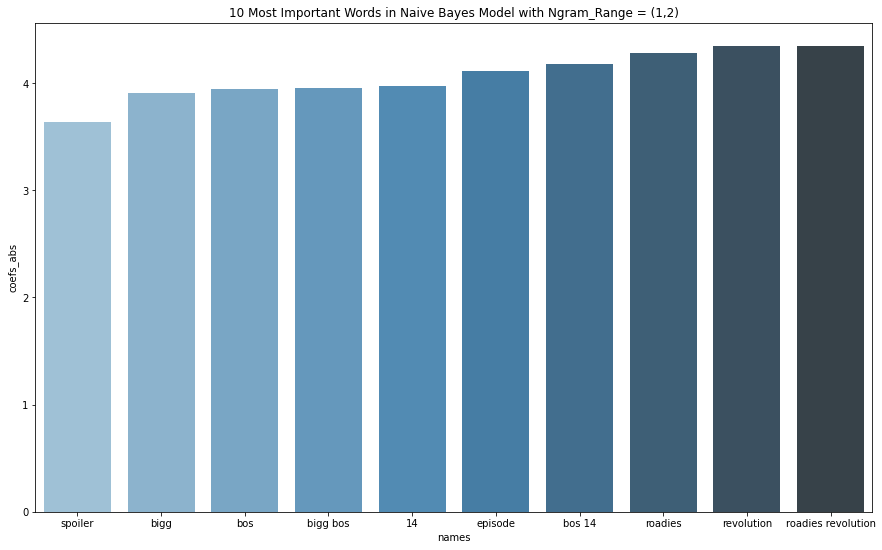

In [50]:
ax, fig = plt.subplots(figsize = (15, 9))

sns.barplot(x="names", y="coefs_abs", data=gs13_top_words2,
                 palette="Blues_d")

plt.title('10 Most Important Words in Naive Bayes Model with Ngram_Range = (1,2)');

In [51]:
gs13_coefs.nsmallest(10, 'coefs')

,coefs,names
49,-22.231557,4k release
50,-22.231557,4k uhd
51,-22.231557,4k version
102,-22.231557,aragorn
110,-22.231557,arwen
128,-22.231557,balrog
130,-22.231557,barad
153,-22.231557,bilbo
163,-22.231557,blockchain
178,-22.231557,box set


One last trick I want to try is to use that custom lemmatizer again with the TfidfVectorizer. That was my best model in Notebook 3 (called pipe4), so I want to see how it does with this newly cleaned dataset.

In [52]:
pipe14 = make_pipeline(TfidfVectorizer(tokenizer = LemmaTokenizer()), MultinomialNB())

In [53]:
params_14= {'tfidfvectorizer__stop_words': [None, 'english'],
         'tfidfvectorizer__max_features': [None, 500, 1000],
         'multinomialnb__alpha': [0, 0.00001, 0.5, 1.0]}

In [54]:
gs14 = GridSearchCV(pipe14, param_grid=params_14, n_jobs=-1)

In [55]:
gs14.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fa30a6256d0>)),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0, 1e-05, 0.5, 1.0],
                         'tfidfvectorizer__max_features': [None, 500, 1000],
                         'tfidfvectorizer__stop_words': [None, 'english']})

In [56]:
eval_model_gs(gs14, X_train, X_test, y_train, y_test)

Your train score is: 0.9593046226787831
Your test score is: 0.9265112603713948
Your best test params were: {'multinomialnb__alpha': 1.0, 'tfidfvectorizer__max_features': None, 'tfidfvectorizer__stop_words': 'english'}
Your test recall/sensitivity score is: 0.8831886345698501
Your confusion matrix is: [[0.96993671 0.03006329]
 [0.11681137 0.88318863]]


So interesting, this model didn't do as well as the dataset with the symbols, special characters, and emojis. But, it still did pretty well! Slightly overfit, but still pretty good.

Well, I think I've taken the MultinomialNB modelling as far as it will go for now. If I have time, I'd like to experiment with stemming and lemmatizing and see if those improve my scores. 